# Boundary conditions

In [1]:
import numpy as np
import scipy as sp
import os
import sys
from scipy import optimize
from scipy import integrate
from scipy import interpolate
from matplotlib import pyplot as plt

## Import model

In [2]:
#current_dir = os.path.dirname(os.path.abspath(__file__))
#model_directory = os.path.join(current_dir, '..', 'cosmotransition_z2sb', 'cosmoTransitions')
model_directory='/Users/quarkquartet/Work/Wall-velocity/model/'
sys.path.append(model_directory)
import baseMo_s_b_d as bm

In [3]:
m = bm.model(702.654702269, -102.146250858, 0.112009439661, 0.0037322807528, -0.0370639674565,10000)

In [4]:
m.findAllTransitions()

Tracing phase starting at x = [246.00000051 572.58176356] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................................
Tracing phase starting at x = [-2.27347289e-07  1.79312356e+02] ; t = 68.27354525855334
Tracing minimum down
traceMinimum t0 = 68.2735
..............................................................................
Tracing minimum up
traceMinimum t0 = 68.2735
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[{'low_vev': array([202.04374412, 482.78409962]),
  'high_vev': array([9.51180104e-06, 1.78261369e+02]),
  'Tnuc': 61.79608446346483,
  'low_phase': 0,
  'high_phase': 1,
  'instanton': fullTunneling_rval(profile1D=Profile1D(R=array([0.00000000e+00, 1.04060051e-05, 1.88910615e-03, 3.76780630e-03,
         5.64650644e-03, 7.52520659e-03, 9.40390674e-03, 1.12826069e-02,
         1.31613070e-02, 1.50400072e-02, 1.69187073e-02, 1.87974075e-02,
         2.06761076e-02, 2.25548078e-02, 2.44335079e-02, 2.63122081e-02,
         2.81909082e-02, 3.00696083e-02, 3.19483085e-02, 3.38270086e-02,
         3.57057088e-02, 3.75844089e-02, 3.94631091e-02, 4.13418092e-02,
         4.32205094e-02, 4.50992095e-02, 4.69779097e-02, 4.88566098e-02,
         5.07353100e-02, 5.26140101e-02, 5.44927102e-02, 5.63714104e-02,
         5.82501105e-02, 6.01288107e-02, 6.20075108e-02, 6.38862110e-02,
         6.57649111e-02, 6.76436113e-02, 6.95223114e-02, 7.14010116e-02,
         7.32797117e-02, 7.51584118e-02, 7.70

In [37]:
m.TnTrans[0].keys()

dict_keys(['low_vev', 'high_vev', 'Tnuc', 'low_phase', 'high_phase', 'instanton', 'action', 'trantype', 'crit_trans', 'rho+', 'rho-', 'p+', 'p-', 'ep+', 'ep-'])

In [5]:
hv = m.TnTrans[0]['high_vev']
lv = m.TnTrans[0]['low_vev']
Tnuc = m.TnTrans[0]['Tnuc']
Vtot = m.Vtot

## Thermodynamic quantities

In [6]:
def derivative(f, x, eps=1e-5, order=1):
    """Calculate the derivative of a function.
    Using Ridders algorithm.
    Calculate up to order x**4.
    Only compute 1st or 2nd order derivative."""
    assert (
        order == 1 or order == 2
    ), "Calculate derivative up to an order, must be 1 or 2."
    δx = x * eps
    if order == 1:
        return (f(x - 2 * δx) - 8 * f(x - δx) + 8 * f(x + δx) - f(x + 2 * δx)) / (
            12 * δx
        )
    if order == 2:
        return (f(x - 2 * δx) - f(x - δx) - f(x + δx) + f(x + 2 * δx)) / (3 * δx**2)

In [7]:
def cs_sq(V,T, vev):
    """Sound speed square."""
    def VT(T):
        return V(vev,T)
    return derivative(VT, T, order=1)/(T*derivative(VT, T, order=2))

In [9]:
cs_sq(Vtot, Tnuc, hv)

0.33379900900581405

In [10]:
cs_sq(Vtot, Tnuc,lv)

0.29347226243359037

In [8]:
def epsilon(V,T,vev):
    """Epsilon."""
    def VT(T):
        return V(vev,T)
    return - 0.25*T*derivative(VT,T) + VT(T)

def a(V,T, vev):
    """The parameter a, means the effective dofs."""
    def VT(T):
        return V(vev,T)
    return - 0.75 * derivative(VT,T)/T**3


def alpha_p(V, Tp, Tm, high_vev, low_vev):
    return (epsilon(V,Tp,high_vev) - epsilon(V,Tm, low_vev))/(a(V,Tp, high_vev) * Tp**4)

def r_func(V,Tp,Tm, high_vev, low_vev):
    return a(V,Tp, high_vev)*Tp**4/(a(V,Tm, low_vev)*Tm**4)

def w(V, T, vev):
    def VT(T):
        return V(vev, T)
    return - T * derivative(VT,T)

## Solve detonation

In [13]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

In [16]:
match(0.7,0.5,61.8, 61.0, hv,lv)

[0.37488767629163944, 0.676399039862079]

In [17]:
def guess_det(vp, Tp, ap, am, εp, εm):
    αp = (εp-εm)/(ap*Tp**4)
    r=1/(1+3*αp)
    Tm = (ap*Tp**4/(am*r))**0.25
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    vm = min(vpvm/vp, 0.67)
    return [vm,Tm]

In [18]:
def vJ(alphap):
    v = (alphap*(2+3*alphap))**0.5 + 1
    v = v/((1+alphap)*3**0.5)
    return v

In [24]:
vJ(0.050858596835864606)

0.7311924971667051

In [21]:
vw=0.6
guess = guess_det(vw, m.TnTrans[0]['Tnuc'],a(m.Vtot,  m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev']), a(m.Vtot,m.TnTrans[0]['Tnuc']*1.1,m.TnTrans[0]['low_vev']),epsilon(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['high_vev']), epsilon(m.Vtot, m.TnTrans[0]['Tnuc'], m.TnTrans[0]['low_vev']))
print(guess)
optimize.fsolve(lambda x:match(vw, x[0], m.TnTrans[0]['Tnuc'], x[1], m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),guess, xtol=1e-10)

[0.67, 69.4428590655021]


/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([ 0.40596061, 81.51196995])

In [18]:
optimize.fsolve(lambda x:match(0.7, x[0], m.TnTrans[0]['Tnuc'], x[1], m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),guess, xtol=1e-10)

/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([ 0.50929031, 78.62803497])

## Solve deflagration

Try to solve the deflagration solution with vw = 0.5

In [14]:
guess_sol = optimize.fsolve(lambda x:match(x[0],0.5,x[1], 60, hv, lv),[0.3, Tnuc], xtol=1e-10)
guess_sol

array([ 0.31077114, 66.30557572])

In [15]:
def dYda(tau, y, *args):
    """Y: (v, xi, T)"""
    v = y[0]
    xi = y[2]
    T = y[1]
    V=args[0]
    vev=args[1]
    dvdtau = 2 * v * cs_sq(V, T, vev) * (1-v**2) * (1- xi * v)
    dxidtau = xi *((xi-v)**2 - cs_sq(V,T,vev) * (1-xi*v)**2)
    dvdxi = 2*v/xi * (1-v**2)
    dvdxi = dvdxi/(1-v*xi)/(μ(xi, v)**2/cs_sq(V,T,vev) - 1)
    dTdxi = T * μ(xi, v) * dvdxi / (1-v**2)
    dTdtau = dTdxi * dxidtau
    return np.array([dvdtau, dTdtau, dxidtau])

def μ(x, v):
    return (x-v)/(1-x*v)


In [16]:
vsol=integrate.solve_ivp(dYda, (10,1), np.array([μ(0.5, guess_sol[0]), guess_sol[1], 0.5]),t_eval=np.linspace(10,1,1000),method='DOP853', args=(Vtot,hv))

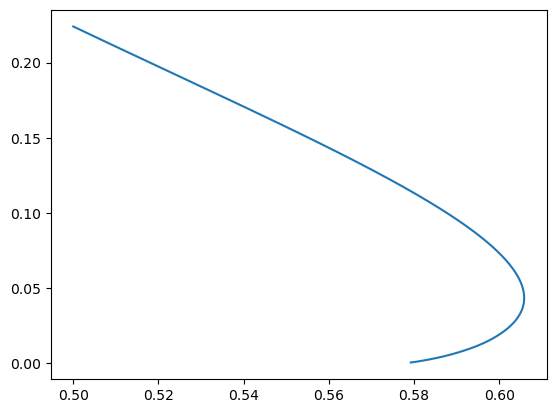

In [25]:
plt.plot(vsol.y[2],vsol.y[0])

In [28]:
xi_max = vsol.y[2].max()
xi_max_index = vsol.y[2].argmax()
v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1], vsol.y[0][0:xi_max_index+1], kind='cubic')
T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1], vsol.y[1][0:xi_max_index+1], kind='cubic')

In [29]:
xi_max

0.605831301288266

In [30]:
vsol.t[xi_max_index]

7.342342342342342

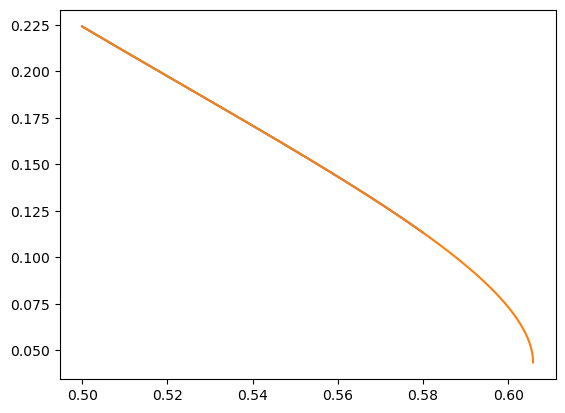

In [31]:
xplot = np.linspace(0.5, 0.58, 100)
vplot = [v_prof(x) for x in xplot]
plt.plot(xplot, vplot)
plt.plot(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])

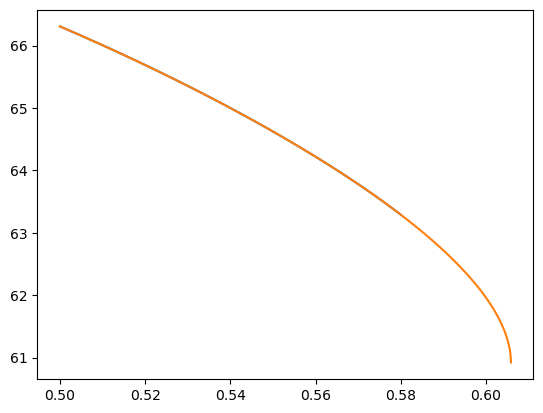

In [33]:
xplot = np.linspace(0.5, 0.58, 100)
Tplot = [T_prof(x) for x in xplot]
plt.plot(xplot, Tplot)
plt.plot(vsol.y[2][0:xi_max_index+1], vsol.y[1][0:xi_max_index+1])

In [34]:
xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), 0.5, xi_max*0.999)
xsh

0.6013272537273485

In [35]:
T_prof(xsh)

array(61.82340948)

In [17]:
def find_Tsh(Tm):
    guess_sol = optimize.fsolve(lambda x:match(x[0], 0.5, x[1], Tm,m.TnTrans[0]['high_vev'], m.TnTrans[0]['low_vev']),[0.1, m.TnTrans[0]['Tnuc']])
    vsol=integrate.solve_ivp(dYda, (10,0.01), np.array([μ(0.5, guess_sol[0]), guess_sol[1], 0.5]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
    xi_max = vsol.y[2].max()
    xi_max_index = vsol.y[2].argmax()
    v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
    T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
    xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), 0.5, xi_max*0.9999)
    return T_prof(xsh)

In [18]:
find_Tsh(55)

array(58.32940369)

In [19]:
Tmax = m.TnTrans[0]['Tnuc']
Tmin = 58
for i in range(30):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal)
    if Tsh < m.TnTrans[0]['Tnuc']:
        Tmin = Tcal
    else:
        Tmax = Tcal

In [64]:
Tcal

59.962963788577525

In [68]:
find_Tsh(Tcal)

array(61.79613023)

In [42]:
m.TnTrans[0]['Tnuc']

61.79608446346483

In [20]:
Tm = Tcal
vp, Tp = optimize.fsolve(lambda x:match(x[0],0.5,x[1], Tcal, hv, lv),[0.3, Tnuc], xtol=1e-10)
print(vp, Tp)

0.31047522910630265 66.27942104354211


In [77]:
print(lv, hv)

[202.04374412 482.78409962] [9.51180104e-06 1.78261369e+02]


### Solve the temperature profile

In [21]:
h0 = lv[0]
s0 = lv[1]-hv[1]
s_initial=hv[1]

In [22]:
def h_profile(z,Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz

def s_profile(z, Ls, deltas):
    z = np.asanyarray(z)
    sz = 0.5*s0*(1-np.tanh(z/Ls + deltas)) + s_initial
    return sz

In [23]:
integrate.quad(lambda z: m.gradV([h_profile(z, 1.0), s_profile(z, 1.0, 5)],60)[0], -50, 50)

(2875995.5076784138, 0.041634234009750165)

In [24]:
c1 = w(Vtot, Tp, hv) * vp/(1-vp**2)
s1=c1
c2=-Vtot(hv, Tp) + w(Vtot, Tp, hv) * vp**2 /(1-vp**2)
s2=c2

In [25]:
def T33(T,z, Lh, Ls, deltas):
    derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
    ders = derivative(lambda zvalue: s_profile(zvalue,Ls,deltas),z)
    field_value = [h_profile(z, Lh), s_profile(z, Ls, deltas)]
    return 0.5*(derh**2 + ders**2) - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2

In [208]:
Tplot = np.linspace(55, 70, 100)
T33plot = [T33(T, -10,1.0,1.0,5.0) for T in Tplot]

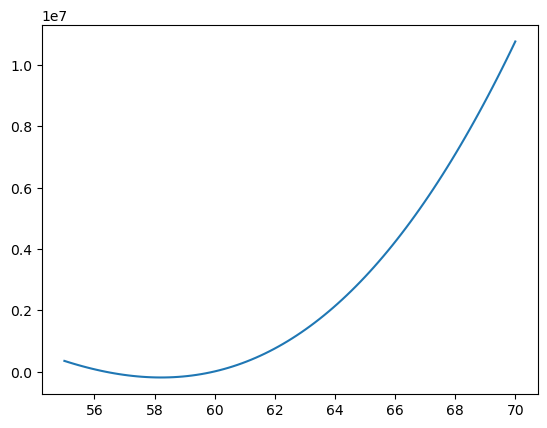

In [209]:
plt.plot(Tplot, T33plot)

In [26]:
optimize.fsolve(lambda T: T33(T[0], 0.2, 1.0, 1.0, 5.0), 66)

array([66.48024828])

In [216]:
zplot = np.linspace(-20,20,1000)
Tplot = [optimize.fsolve(lambda T: T33(T[0], z, 1.0, 1.0, 5.0), 60)[0] for z in zplot]

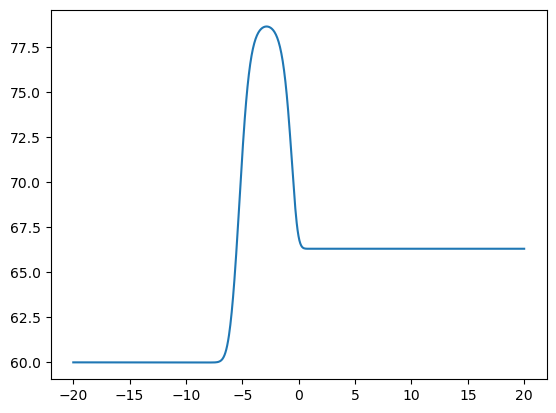

In [217]:
plt.plot(zplot, Tplot)

In [225]:
T_prof = interpolate.interp1d(zplot, Tplot, kind='cubic')

### Solve moments

In [271]:
def np_integrate(f, xmin, xmax, grids):
    x_grids = np.linspace(xmin, xmax, grids)
    f_grids = [f(x) for x in x_grids]
    return np.trapz(f_grids, x_grids)

In [27]:
Sech = lambda x: 1/np.cosh(x)
def moments(Lh, Ls, deltas):
    z_range = np.linspace(-10*max(Lh,Ls), 10*max(Lh,Ls), 500)
    zmin, zmax = z_range[0], z_range[-1]
    T_sol = [optimize.fsolve(lambda T: T33(T[0], z, Lh, Ls, deltas), Tnuc)[0] for z in z_range]
    T_prof = interpolate.interp1d(z_range, T_sol, kind='cubic')
    Eh = lambda z: m.gradV([h_profile(z, Lh), s_profile(z, Ls, deltas)], T_prof(z))[0]
    Es = lambda z: m.gradV([h_profile(z, Lh), s_profile(z, Ls, deltas)], T_prof(z))[1]
    hprime = lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh
    sprime = lambda z: -0.5*(s0*Sech(deltas + z/Ls)**2)/Ls
    Ph = integrate.quad(lambda z: - Eh(z) * hprime(z), zmin, zmax)[0]
    Gh = integrate.quad(lambda z: - Eh(z) * hprime(z) * np.tanh(z/Lh), zmin, zmax)[0]
    Ps = integrate.quad(lambda z: - Es(z) * sprime(z), zmin, zmax)[0]
    Gs = integrate.quad(lambda z: - Es(z) * sprime(z) * np.tanh(z/Ls + deltas), zmin, zmax)[0]
    return np.array([Ph, Ps, Gh, Gs])

In [35]:
def Ph(Lh, Ls, deltas):
    z_range = np.linspace(-20*Lh, 20*Lh, 500)
    zmin, zmax = z_range[0], z_range[-1]
    T_sol = [optimize.fsolve(lambda T: T33(T[0], z, Lh, Ls, deltas), Tnuc)[0] for z in z_range]
    T_prof = interpolate.interp1d(z_range, T_sol, kind='cubic')
    Eh = lambda z: m.gradV([h_profile(z, Lh), s_profile(z, Ls, deltas)], T_prof(z))[0]
    hprime = lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh
    Ph = integrate.quad(lambda z: - Eh(z) * hprime(z), zmin, zmax)[0]
    return Ph

def Gh(Lh, Ls, deltas):
    z_range = np.linspace(-20*Lh, 20*Lh, 500)
    zmin, zmax = z_range[0], z_range[-1]
    T_sol = [optimize.fsolve(lambda T: T33(T[0], z, Lh, Ls, deltas), Tnuc)[0] for z in z_range]
    T_prof = interpolate.interp1d(z_range, T_sol, kind='cubic')
    Eh = lambda z: m.gradV([h_profile(z, Lh), s_profile(z, Ls, deltas)], T_prof(z))[0]
    hprime = lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh
    Gh = integrate.quad(lambda z: - Eh(z) * hprime(z) * np.tanh(z/Lh), zmin, zmax)[0]
    return Gh

def Ps(Lh, Ls, deltas):
    z_range = np.linspace(-20*Ls, 20*Ls, 500)
    zmin, zmax = z_range[0], z_range[-1]
    T_sol = [optimize.fsolve(lambda T: T33(T[0], z, Lh, Ls, deltas), Tnuc)[0] for z in z_range]
    T_prof = interpolate.interp1d(z_range, T_sol, kind='cubic')
    Es = lambda z: m.gradV([h_profile(z, Lh), s_profile(z, Ls, deltas)], T_prof(z))[1]
    sprime = lambda z: -0.5*(s0*Sech(deltas + z/Ls)**2)/Ls
    Ps = integrate.quad(lambda z: - Es(z) * sprime(z), zmin, zmax)[0]
    return Ps

def Gs(Lh, Ls, deltas):
    z_range = np.linspace(-20*Ls, 20*Ls, 500)
    zmin, zmax = z_range[0], z_range[-1]
    T_sol = [optimize.fsolve(lambda T: T33(T[0], z, Lh, Ls, deltas), Tnuc)[0] for z in z_range]
    T_prof = interpolate.interp1d(z_range, T_sol, kind='cubic')
    Es = lambda z: m.gradV([h_profile(z, Lh), s_profile(z, Ls, deltas)], T_prof(z))[1]
    sprime = lambda z: -0.5*(s0*Sech(deltas + z/Ls)**2)/Ls
    Gs = integrate.quad(lambda z: - Es(z) * sprime(z) * np.tanh(z/Lh), zmin, zmax)[0]
    return Gs

In [43]:
def solve_Lh(Ls, deltas):
    lhrange=np.linspace(0.1,10,50)
    Ghrange = []
    for lh in lhrange:
        Ghrange.append(Gh(lh, Ls, deltas))
    Ghfunc=interpolate.interp1d(lhrange, Ghrange)
    return optimize.brentq(Ghfunc, 0.1, 10, kind='cubic')

In [36]:
lhrange=np.linspace(0.1,10,50)
Ghrange = []
for lh in lhrange:
    Ghrange.append(Gh(lh, 1.0, 0.1))
Ghfunc=interpolate.interp1d(lhrange, Ghrange)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_4004/3646235961.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Gh = integrate.quad(lambda z: - Eh(z) * hprime(z) * np.tanh(z/Lh), zmin, zmax)[0]


In [40]:
Ghfunc=interpolate.interp1d(lhrange, Ghrange,kind='cubic')

In [41]:
optimize.brentq(Ghfunc,0.1,1.1)

0.8410475685193577

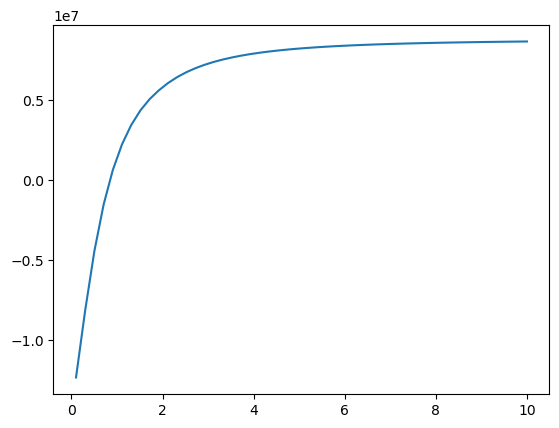

In [37]:
plt.plot(lhrange, Ghrange)

In [33]:
solve_Lh(1.0, 0.1)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_4004/497768530.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Gh = integrate.quad(lambda z: - Eh(z) * hprime(z) * np.tanh(z/Lh), zmin, zmax)[0]


0.8476199883095916

In [42]:
Gh(0.8410475685193577, 1.0, 0.1)

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_4004/3646235961.py:18: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Gh = integrate.quad(lambda z: - Eh(z) * hprime(z) * np.tanh(z/Lh), zmin, zmax)[0]


188.32834081673354

In [270]:
lhrange = np.linspace(0.1, 10, 100)
Grange_1 = []
Grange_01 = []
Grange_5 = []
for lh in lhrange:
    Ph, Ps, Gh, Gs=moments(lh, 1.0, 0.5)
    Grange_1.append([Gh,Gs])
    Ph, Ps, Gh, Gs=moments(lh, 0.1, 0.5)
    Grange_01.append([Gh,Gs]) 
    Ph, Ps, Gh, Gs=moments(lh, 5.0, 0.5)
    Grange_5.append([Gh,Gs])

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_614/1384171039.py:13: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Gs = integrate.quad(lambda z: - Es(z) * sprime(z) * np.tanh(z/Ls + deltas), zmin, zmax)[0]
/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_614/1384171039.py:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, disco

TypeError: list indices must be integers or slices, not tuple

Text(0, 0.5, '$G_h$')

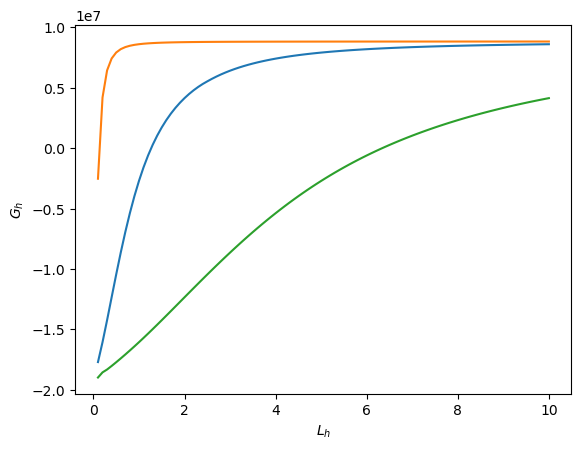

In [281]:
plt.plot(lhrange, np.array(Grange_1)[:,0])
plt.plot(lhrange, np.array(Grange_01)[:,0])
plt.plot(lhrange, np.array(Grange_5)[:,0])
plt.xlabel(r'$L_h$')
plt.ylabel(r'$G_h$')

Text(0, 0.5, '$G_s$')

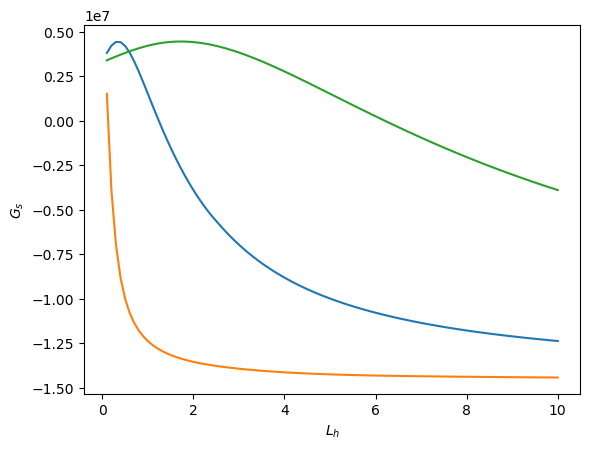

In [282]:
plt.plot(lhrange, np.array(Grange_1)[:,1])
plt.plot(lhrange, np.array(Grange_01)[:,1])
plt.plot(lhrange, np.array(Grange_5)[:,1])
plt.xlabel(r'$L_h$')
plt.ylabel(r'$G_s$')

In [267]:
def match_width(Lh,Ls,deltas):
    Ph, Ps, Gh, Gs = moments(Lh, Ls, deltas)
    return [Gh, Gs]

In [268]:
optimize.fsolve(lambda L: match_width(L[0],L[1], 0.1), [0.5, 0.5])

/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([ 97.36670884, 107.24949418])

In [283]:
optimize.root(lambda L: match_width(L[0],L[1], 0.1), [0.5, 0.5])

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 6.439e+05  7.400e+05]
       x: [ 9.737e+01  1.072e+02]
    nfev: 36
    fjac: [[-7.540e-01  6.568e-01]
           [-6.568e-01 -7.540e-01]]
       r: [-1.349e+05  1.224e+05  7.328e-02]
     qtf: [ 3.334e+03 -9.809e+05]

In [269]:
moments(97.36670884, 107.24949418, 0.1)

array([-3949365.16563566,  2893728.53231175,   643903.75645292,
         739975.02108517])

In [44]:
def moment_match(Lh, Ls, deltas):
    Ph, Ps, Gh, Gs = moments(Lh, Ls, deltas)
    return [Ph-Ps, Gh, Gs]

In [246]:
optimize.fsolve(lambda L: moment_match(L[0], L[1], L[2]), [1.0, 1.0, 5.0])

/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([-177.24647677, -170.61162837, -448.08816308])

In [162]:
lhrange=np.linspace(0.1,2,30)
lsrange=np.linspace(0.1,2,30)
deltasrange = np.linspace(0.01,1, 30)
Pdiff = np.zeros((30,30,30))
Ghrange = np.zeros((30,30,30))
Gsrange = np.zeros((30,30,30))

In [163]:
for i in range(30):
    for j in range(30):
        for k in range(30):
            Pdiff[i,j,k], Ghrange[i,j,k], Gsrange[i,j,k] = moment_match(lhrange[i], lsrange[j], deltasrange[k])

/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_4004/1300040809.py:12: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Gh = integrate.quad(lambda z: - Eh(z) * hprime(z) * np.tanh(z/Lh), zmin, zmax)[0]
/var/folders/mw/3xz76j416k761n077pnr10nc0000gn/T/ipykernel_4004/1300040809.py:11: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuit

In [164]:
Pdiff_func = interpolate.RegularGridInterpolator((lhrange, lsrange, deltasrange),Pdiff)
Gh_func = interpolate.RegularGridInterpolator((lhrange, lsrange, deltasrange),Ghrange)
Gs_func = interpolate.RegularGridInterpolator((lhrange, lsrange, deltasrange),Gsrange)

In [165]:
def match_interpolate(L):
    return np.array([Pdiff_func(L)[0], Gh_func(L)[0], Gs_func(L)[0]])

In [148]:
match_interpolate([0.9,0.77,0.24])

array([-4587492.0090067 ,  1163832.92671139,  -673522.94950171])

In [173]:
sol=optimize.fsolve(match_interpolate, [0.6, 0.5, 0.1])

ValueError: One of the requested xi is out of bounds in dimension 0

In [157]:
moment_match(sol[0],sol[1], sol[2])

[581671.3529335443, 139212.15650277314, 588112.9591836643]

In [158]:
match_interpolate(sol)

array([ 9.66852531e-06, -4.72820830e-06,  5.71686542e-07])

In [250]:
moments(177.24647677, 170.61162837, -448.08816308)

array([-34212365.44344092,         0.        ,   3365024.03471949,
              -0.        ])

In [257]:
optimize.minimize(moment_min, [0.3,0.3, 100])

/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/Users/quarkquartet/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 2257510152639507.5
        x: [ 3.000e-01  3.000e-01  1.000e+02]
      nit: 0
      jac: [ 3.238e+12 -2.087e+11  0.000e+00]
 hess_inv: [[1 0 0]
            [0 1 0]
            [0 0 1]]
     nfev: 128
     njev: 30